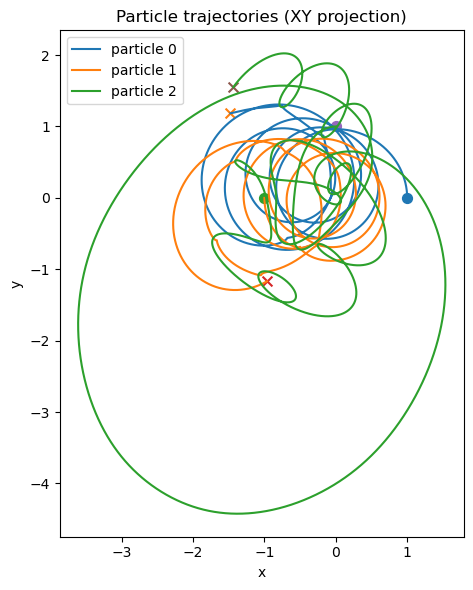

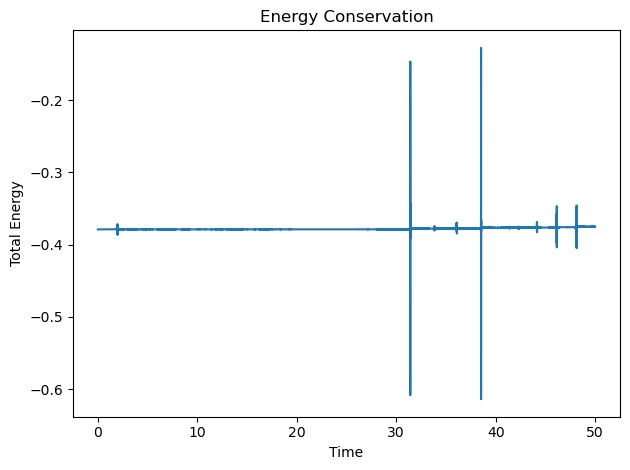

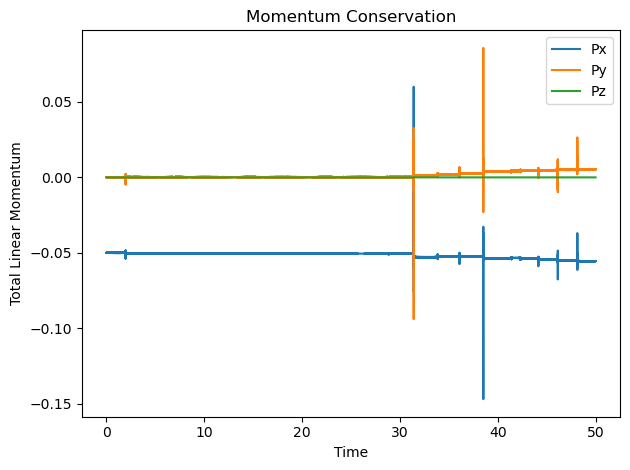

In [3]:
import numpy as np
import matplotlib.pyplot as plt

G = 1.0               # gravitational constant
SOFT = 1e-3           # softening length
ETA  = 0.01           # accuracy parameter for time-step
DT_MIN = 1e-4         # minimum allowed dt
DT_MAX = 1e-1         # maximum allowed dt

class Particle:
    def __init__(self, m, x, v):
        self.m = m
        self.x = np.array(x, dtype=float)
        self.v = np.array(v, dtype=float)
        self.t = 0.0
        self.dt = DT_MIN
        self.next_t = DT_MIN

        # trajectory
        self.times = [self.t]
        self.positions = [self.x.copy()]

def accel(i, particles):
    ai = np.zeros(3)
    pi = particles[i]
    for j, pj in enumerate(particles):
        if j == i: continue
        r = pj.x - pi.x
        dist2 = np.dot(r, r) + SOFT*SOFT
        ai += G * pj.m * r / (dist2 * np.sqrt(dist2))
    return ai

def compute_dt(a):
    a_norm = np.linalg.norm(a)
    dt = ETA * np.sqrt((SOFT + 1e-8) / (a_norm + 1e-12))
    return np.clip(dt, DT_MIN, DT_MAX)

def compute_energy(particles):
    # Kinetic energy
    KE = sum(0.5 * p.m * np.dot(p.v, p.v) for p in particles)
    # Potential energy
    PE = 0.0
    N = len(particles)
    for i in range(N):
        for j in range(i):
            r = particles[i].x - particles[j].x
            dist = np.sqrt(np.dot(r, r) + SOFT*SOFT)
            PE -= G * particles[i].m * particles[j].m / dist
    return KE + PE

def compute_momentum(particles):
    P = np.zeros(3)
    for p in particles:
        P += p.m * p.v
    return P

def evolve(particles, t_end):
    t = 0.0
    # init
    for i, p in enumerate(particles):
        a = accel(i, particles)
        p.dt = compute_dt(a)
        p.next_t = p.dt

    # conservation arrays
    times = [0.0]
    energies = [compute_energy(particles)]
    momenta = [compute_momentum(particles)]

    while t < t_end:
        t_next = min(p.next_t for p in particles)
        if t_next > t_end:
            for p in particles:
                dt_drift = t_end - p.t
                p.x += p.v * dt_drift
                p.t = t_end
                p.times.append(p.t)
                p.positions.append(p.x.copy())
            t = t_end
            times.append(t)
            energies.append(compute_energy(particles))
            momenta.append(compute_momentum(particles))
            break

        # drift
        for p in particles:
            dt_drift = t_next - p.t
            p.x += p.v * dt_drift
            p.t = t_next
            p.times.append(p.t)
            p.positions.append(p.x.copy())

        # kick
        for i, p in enumerate(particles):
            if abs(p.next_t - t_next) < 1e-12:
                a = accel(i, particles)
                p.v += a * p.dt
                p.dt = compute_dt(a)
                p.next_t = p.t + p.dt

        t = t_next
        times.append(t)
        energies.append(compute_energy(particles))
        momenta.append(compute_momentum(particles))

    return times, energies, momenta

# --- run example and plot ---
if __name__ == "__main__":
    particles = [
        Particle(1.0, [ 1.0, 0.0, 0.0], [ 0.0, 0.5, 0.0]),
        Particle(1.0, [-1.0, 0.0, 0.0], [ 0.0,-0.5, 0.0]),
        Particle(0.1, [ 0.0, 1.0, 0.0], [-0.5, 0.0, 0.0]),
    ]
    times, energies, momenta = evolve(particles, t_end=50.0)

    # ----- plot trajectories -----
    fig, ax = plt.subplots(figsize=(6,6))
    for i, p in enumerate(particles):
        traj = np.array(p.positions)
        ax.plot(traj[:,0], traj[:,1], label=f'particle {i}')
        ax.scatter(traj[0,0], traj[0,1], marker='o', s=50)  # start
        ax.scatter(traj[-1,0], traj[-1,1], marker='x', s=50)  # end

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', 'box')
    ax.legend()
    ax.set_title('Particle trajectories (XY projection)')
    plt.tight_layout()
    plt.show()


    # Plot total energy vs time
    plt.figure()
    plt.plot(times, energies)
    plt.xlabel('Time')
    plt.ylabel('Total Energy')
    plt.title('Energy Conservation')
    plt.tight_layout()
    plt.show()

    # Plot total momentum components vs time
    mom_arr = np.array(momenta)
    plt.figure()
    plt.plot(times, mom_arr[:,0], label='Px')
    plt.plot(times, mom_arr[:,1], label='Py')
    plt.plot(times, mom_arr[:,2], label='Pz')
    plt.xlabel('Time')
    plt.ylabel('Total Linear Momentum')
    plt.title('Momentum Conservation')
    plt.legend()
    plt.tight_layout()
    plt.show()

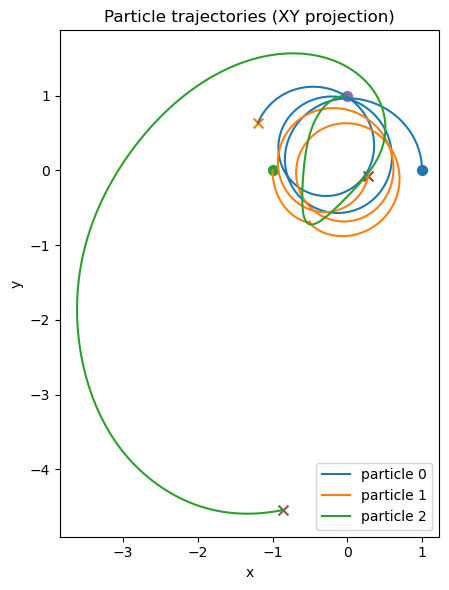

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # only if you want 3D plots

G = 1.0               # gravitational constant
SOFT = 1e-3           # softening length
ETA  = 0.001           # accuracy parameter for time-step
DT_MIN = 1e-4         # minimum allowed dt
DT_MAX = 1e-1         # maximum allowed dt

class Particle:
    def __init__(self, m, x, v):
        self.m = m
        self.x = np.array(x, dtype=float)
        self.v = np.array(v, dtype=float)
        self.t = 0.0            # last‐update time
        self.dt = DT_MIN        # current time‐step
        self.next_t = DT_MIN    # next scheduled update

        # for trajectory recording:
        self.times = [self.t]
        self.positions = [self.x.copy()]

def accel(i, particles):
    ai = np.zeros(3)
    pi = particles[i]
    for j, pj in enumerate(particles):
        if j == i: continue
        r = pj.x - pi.x
        dist2 = np.dot(r, r) + SOFT*SOFT
        ai += G * pj.m * r / (dist2 * np.sqrt(dist2))
    return ai

def compute_dt(a):
    a_norm = np.linalg.norm(a)
    dt = ETA * np.sqrt((SOFT + 1e-8) / (a_norm + 1e-12))
    return np.clip(dt, DT_MIN, DT_MAX)

def evolve(particles, t_end):
    t = 0.0
    # initialize accelerations & timesteps
    for i, p in enumerate(particles):
        a = accel(i, particles)
        p.dt = compute_dt(a)
        p.next_t = p.dt

    while t < t_end:
        # 1) find the next event time
        t_next = min(p.next_t for p in particles)
        if t_next > t_end:
            # final drift to t_end
            for p in particles:
                p.x += p.v * (t_end - p.t)
                p.t = t_end
                p.times.append(p.t)
                p.positions.append(p.x.copy())
            break

        # 2) drift all particles to t_next
        for p in particles:
            dt_drift = t_next - p.t
            p.x += p.v * dt_drift
            p.t = t_next
            # record after drift
            p.times.append(p.t)
            p.positions.append(p.x.copy())

        # 3) kick velocities & reschedule only those due
        for i, p in enumerate(particles):
            if abs(p.next_t - t_next) < 1e-12:
                a = accel(i, particles)
                p.v += a * p.dt
                p.dt = compute_dt(a)
                p.next_t = p.t + p.dt

        t = t_next

if __name__ == "__main__":
    # --- simple test system ---
    particles = [
        Particle(1.0, [ 1.0, 0.0, 0.0], [ 0.0, 0.5, 0.0]),
        Particle(1.0, [-1.0, 0.0, 0.0], [ 0.0,-0.5, 0.0]),
        Particle(0.1, [ 0.0, 1.0, 0.0], [-0.5, 0.0, 0.0]),
    ]

    # run the simulation
    #evolve(particles, t_end=10.0)
    evolve(particles, t_end=20.0)

    # ----- plot trajectories -----
    fig, ax = plt.subplots(figsize=(6,6))
    for i, p in enumerate(particles):
        traj = np.array(p.positions)
        ax.plot(traj[:,0], traj[:,1], label=f'particle {i}')
        ax.scatter(traj[0,0], traj[0,1], marker='o', s=50)  # start
        ax.scatter(traj[-1,0], traj[-1,1], marker='x', s=50)  # end

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', 'box')
    ax.legend()
    ax.set_title('Particle trajectories (XY projection)')
    plt.tight_layout()
    plt.show()

    # --- if you want a full 3D view, uncomment below ---
    # fig3 = plt.figure()
    # ax3 = fig3.add_subplot(111, projection='3d')
    # for p in particles:
    #     traj = np.array(p.positions)
    #     ax3.plot(traj[:,0], traj[:,1], traj[:,2])
    # ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('z')
    # ax3.set_title('3D trajectories')
    # plt.show()


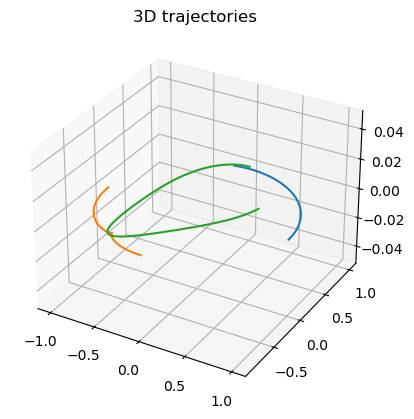

In [5]:
  # --- if you want a full 3D view, uncomment below ---
fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')
for p in particles:
    traj = np.array(p.positions)
    ax3.plot(traj[:,0], traj[:,1], traj[:,2])
# ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('z')
ax3.set_title('3D trajectories')
plt.show()

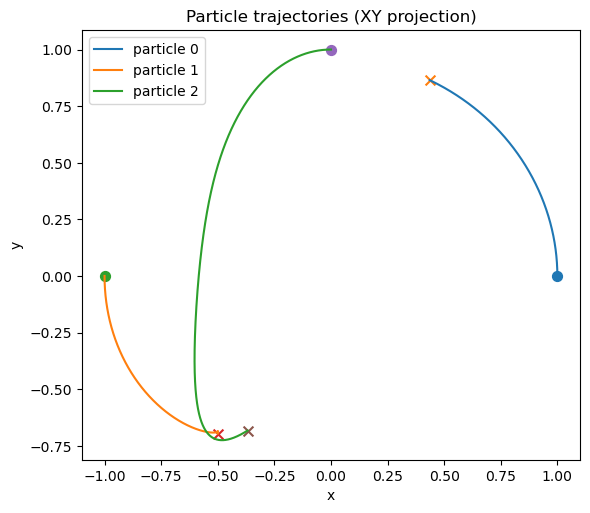

In [9]:
# --- simple test system ---
particles = [
    Particle(1.0, [ 1.0, 0.0, 0.0], [ 0.0, 0.5, 0.0]),
    Particle(1.0, [-1.0, 0.0, 0.0], [ 0.0,-0.5, 0.0]),
    Particle(0.1, [ 0.0, 1.0, 0.0], [-0.5, 0.0, 0.0]),
]

# run the simulation
#evolve(particles, t_end=10.0)
evolve(particles, t_end=2.0)

# ----- plot trajectories -----
fig, ax = plt.subplots(figsize=(6,6))
for i, p in enumerate(particles):
    traj = np.array(p.positions)
    ax.plot(traj[:,0], traj[:,1], label=f'particle {i}')
    ax.scatter(traj[0,0], traj[0,1], marker='o', s=50)  # start
    ax.scatter(traj[-1,0], traj[-1,1], marker='x', s=50)  # end

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', 'box')
ax.legend()
ax.set_title('Particle trajectories (XY projection)')
plt.tight_layout()
plt.show()